In [1]:
import numpy as np
import gudhi as gd
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import BallTree
from sklearn.datasets import make_blobs

# Methods

In [2]:
# Gudhi - For completeness.
def Gudhi_Method(Data, t_cutoff):
    start_time = time.time()
    rips_complex = gd.RipsComplex(points=Data/2, max_edge_length=t_cutoff)
    st = rips_complex.create_simplex_tree(max_dimension=2)
    end_time = time.time()
    return st, end_time - start_time

In [3]:
# 1 Distance Matrix method
def pdist_python(X):
    N = X.shape[0]
    dist_matrix = np.zeros((N, N))
    for i in range(N):
        for j in range(i+1, N):
            dist_matrix[i, j] = np.sqrt(np.sum((X[i] - X[j])**2))
            dist_matrix[j, i] = dist_matrix[i, j]
    return dist_matrix

def dMatrix_Method(Data, t_cutoff):  # Note that t_cutoff is not used in this method, but inclused for ease of comparison
    start_time = time.time()
    distances = pdist_python(Data)
    distances /= 2
    simplex_tree = gd.SimplexTree()

    # Add vertices
    for i in range(len(Data)):
        simplex_tree.insert([i], filtration=0.0)

    # Add edges
    for i in range(len(Data)):
        for j in range(i+1, len(Data)):
            simplex_tree.insert([i, j], filtration=distances[i, j])
    end_time = time.time()
    
    return simplex_tree, end_time - start_time

In [4]:
# 2 - Old method 
def old_Method(Data, t_cutoff):
     
    start = time.time()

    # adding the 0-simplices
    N = len(Data)
    simplicialTree = gd.SimplexTree()
    for i in range(N):
        simplicialTree.insert([i], filtration = 0)

    # adding the 1-simplices 
    for i in range(N):
        for j in range(i+1,N):
            d = np.linalg.norm(Data[i]-Data[j])/2
            if d<=t_cutoff:
                simplicialTree.insert([i,j], filtration = d)

    end = time.time()
    return simplicialTree, end-start


In [5]:
# 3 - New Method 
def classix_precomputaiton(D, Optimised=True):
    start_time = time.time()
    centered_data = D - np.mean(D, axis=0)
    X = np.vstack(centered_data)

    U, s, Vt = np.linalg.svd(X, full_matrices=False)
    alpha = U[:, 0] * s[0]

    sort_indices = np.argsort(alpha)
    X_sorted = X[sort_indices]
    end_time = time.time()

    return alpha, X_sorted, end_time - start_time

def new_Algorthim(alpha, Data_Sorted, t_cutoff):
    start_time = time.time()
    simplicialTree = gd.SimplexTree()
    N = len(alpha)
    for i in range(N):
        simplicialTree.insert([i], filtration=0.0)
    for i, a in enumerate(alpha):
        for j in range(i+1, N):
            if abs(a - alpha[j])/2 > t_cutoff:
                break
            d = np.linalg.norm(Data_Sorted[i]-Data_Sorted[j])/2
            if d <= t_cutoff:
                simplicialTree.insert([i, j], filtration=d)
    end_time = time.time()
    return simplicialTree, end_time - start_time

def new_Method(Data, t_cutoff):
    alpha, Data_Sorted, _ = classix_precomputaiton(Data)
    return new_Algorthim(alpha, Data_Sorted, t_cutoff)

In [6]:
# 4 - BallTree Method - Idea to explore 
def ball_tree_Method(Data, t_cutoff):
    start_time = time.time()

    simplicial_tree = gd.SimplexTree()

    for i in range(len(Data)):
        simplicial_tree.insert([i], filtration=0.0)
    tree = BallTree(Data)

    indices, distances = tree.query_radius(Data, r=t_cutoff, return_distance=True)
    for i, (neighbours, distances) in enumerate(zip(indices, distances)):
        for j, distance in zip(neighbours, distances):
            if j > i:
                simplicial_tree.insert([i, j], filtration=distance)

    end_time = time.time()
    return simplicial_tree, end_time - start_time

In [7]:
# Compairing the methods
def Compair(Data, t_cutoff):
    GudhiTree, GudhiTime = Gudhi_Method(Data, t_cutoff)
    dMatrixTree, dMatrixtTime = dMatrix_Method(Data, t_cutoff)
    oldTree, oldTime = old_Method(Data, t_cutoff)
    newTree, newTime = new_Method(Data, t_cutoff)
    ballTree, ballTime = ball_tree_Method(Data, t_cutoff)
    
    return GudhiTime, dMatrixtTime, oldTime, newTime, ballTime
    # return GudhiTree, dMatrixTree, oldTree, newTree, ballTree, GudhiTime, dMatrixtTime, oldTime, classixTime, newTime, ballTime

# Creating Data 
We will be using `from sklearn.datasets import make_blobs` for the synthetic data. 

In [8]:
# Testing the Compair so far
t1,t2,t3,t4,t5 = Compair(make_blobs(n_samples=1000, n_features=2)[0], 0.1)
print(t1,t2,t3,t4,t5)

0.004066944122314453 1.193500280380249 0.647136926651001 0.00041294097900390625 0.0030279159545898438


In [9]:
# Hyperparameters to test 
N = [100, 1000]
D = [2, 10, 100]
Centers = [1, 10, 100]
standard_dev = [0.1, 1, 10]
t_cutoff = [0.1, 1, 10]

methods = [Gudhi_Method, dMatrix_Method, old_Method, new_Method, ball_tree_Method]

In [20]:
# Set the Random Seed
random_seed = 42

n_points = np.linspace(10, 1000, 10, dtype=int)
dim = [2, 10, 100]
standard_dev = [0.1, 1, 10]


df = pd.DataFrame(columns=['n_points', 'dim', 'num_Centers - Standard Deviations', 't_cutoff', 'Method', 'Time'])

for n in n_points:
    for d in dim:
        for s in standard_dev:
            for t in t_cutoff:
                for method in methods:
                    Data = make_blobs(n_samples=n, n_features=d, centers=1, cluster_std=s, random_state=random_seed)[0]
                    _, methodTime = method(Data, t)

                    new_row = pd.DataFrame([{
                        'n_points': n, 
                        'dim': d, 
                        'num_Centers - Standard Deviations': s,
                        't_cutoff': t,
                        'Method': method.__name__,
                        'Time': methodTime
                            }])
                    df = pd.concat([df, new_row], ignore_index=True)


/var/folders/4n/0vpqtfzs0z57c9c_k8wh_pv80000gn/T/ipykernel_17170/1153885038.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


In [21]:
df.head()

,n_points,dim,num_Centers - Standard Deviations,t_cutoff,Method,Time
0,10,2,0.1,0.1,Gudhi_Method,0.000241
1,10,2,0.1,0.1,dMatrix_Method,0.000352
2,10,2,0.1,0.1,old_Method,0.000537
3,10,2,0.1,0.1,new_Method,0.000146
4,10,2,0.1,0.1,ball_tree_Method,0.000209


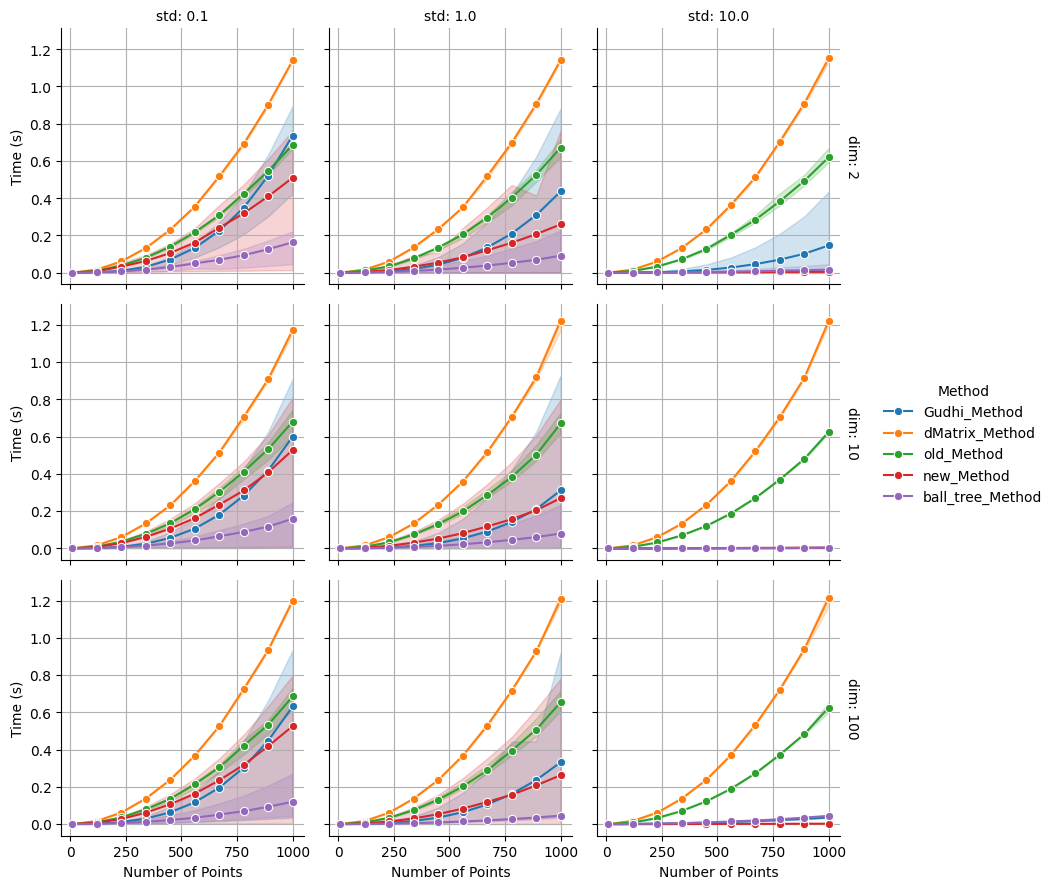

In [25]:
df_1Cluster = df.rename(columns={'num_Centers - Standard Deviations': 'std'})

# df_filtered= df[ df['t_cutoff'] == 0.1]

# Create a FacetGrid for each combination of dim and std
g = sns.FacetGrid(df_1Cluster, row='dim', col='std', hue='Method', margin_titles=True)

# Map the lineplot to the FacetGrid
g.map(sns.lineplot, 'n_points', 'Time', marker='o')

# Add a legend
g.add_legend()

# Add grid lines to each subplot
for ax in g.axes.flatten():
    ax.grid(True)  # Adds grid lines to the individual axes

# Set axis labels with abbreviated names
g.set_axis_labels('Number of Points', 'Time (s)')

# Set abbreviated titles for the rows and columns
g.set_titles(row_template='dim: {row_name}', col_template='std: {col_name}')

# Show the plot
plt.show()

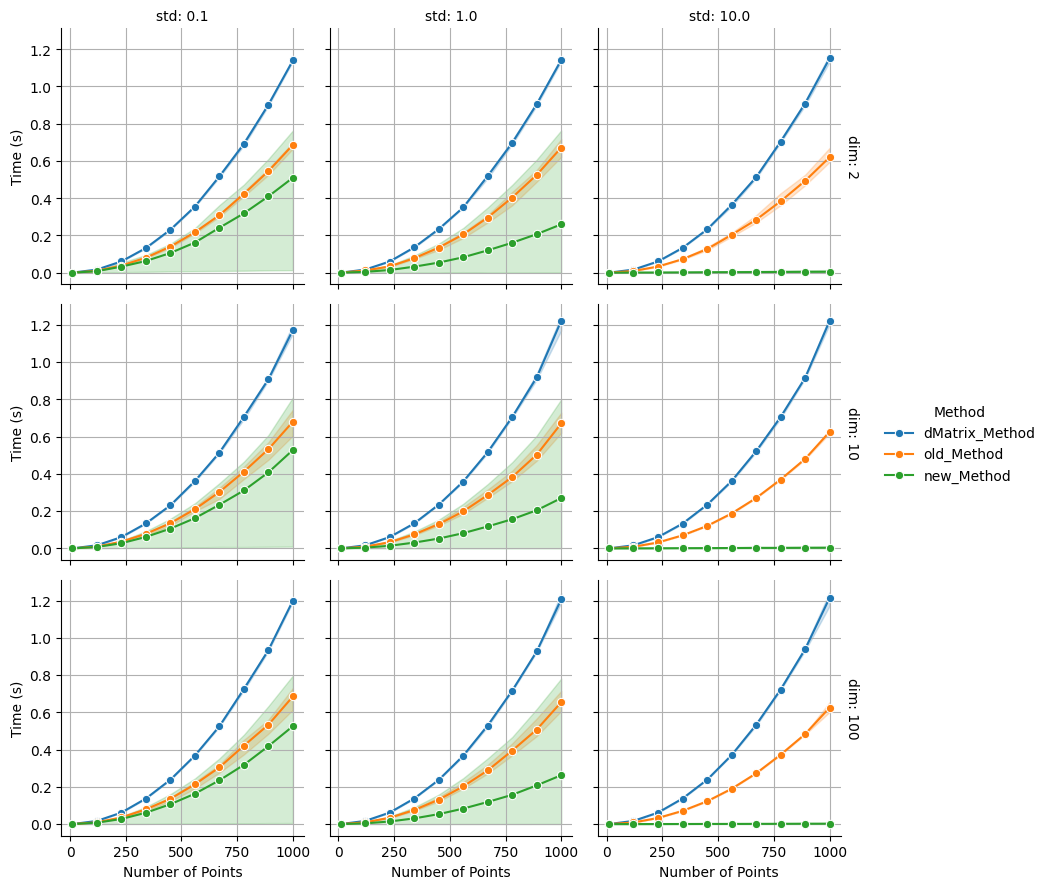

In [27]:
PythonMethods = {'new_Method', 'dMatrix_Method', 'old_Method'}

# Create a FacetGrid for each combination of dim and std
g = sns.FacetGrid(df_1Cluster[ df['Method'].isin(PythonMethods) ], row='dim', col='std', hue='Method', margin_titles=True)

# Map the lineplot to the FacetGrid
g.map(sns.lineplot, 'n_points', 'Time', marker='o')

# Add a legend
g.add_legend()

# Add grid lines to each subplot
for ax in g.axes.flatten():
    ax.grid(True)  # Adds grid lines to the individual axes

# Set axis labels with abbreviated names
g.set_axis_labels('Number of Points', 'Time (s)')

# Set abbreviated titles for the rows and columns
g.set_titles(row_template='dim: {row_name}', col_template='std: {col_name}')

# Show the plot
plt.show()